In [1]:
import pandas as pd
import numpy as np

# --- Configuration ---
INPUT_FILE = "qualtrics_export.csv"

print("Setup loaded. Ready.")

Setup loaded. Ready.


In [2]:
# 1. Read data
# Header row 0, data from row 2 (Index 2)
print(f"Reading file '{INPUT_FILE}' '{INPUT_FILE}' ...")
df_raw = pd.read_csv(INPUT_FILE)
data = df_raw.iloc[2:].copy().reset_index(drop=True)
n_start = len(data)

# 2. Filtering
# 2a) Attention check: column and correct answer
ATTN_CHECK_COL = 'Q51_1'
ATTN_CORRECT_ANSWER = 'Strongly Agree'
n_before_ac = len(data)
data_clean = data[data[ATTN_CHECK_COL] == ATTN_CORRECT_ANSWER].copy()
n_after_ac = len(data_clean)

print("\n--- ATTENTION CHECK ---")
print(f"Before AC filter:   {n_before_ac}")
print(f"After AC filter:    {n_after_ac}")
print(f"Excluded (AC fail): {n_before_ac - n_after_ac}")

# 2b) Manipulation Check (strict exclusion: if 1 is wrong or missing -> out)
mc_key = {
    "Q11": "Verbal",
    "Q38": "Numerical/Percentage",
    "Q50": "Visual/Colour",
}

# Safety: check columns exist
missing_cols = [c for c in mc_key.keys() if c not in data_clean.columns]
if missing_cols:
    raise ValueError(f"Manipulation check columns missing: {missing_cols}")

mc_pass = pd.Series(True, index=data_clean.index)

for col, correct in mc_key.items():
    s = data_clean[col].astype("string").str.strip()
    # missing counts as fail:
    mc_pass &= s.eq(correct).fillna(False)

n_before_mc = len(data_clean)
excluded_mc = data_clean.loc[~mc_pass, "ResponseId"].copy()
data_clean = data_clean.loc[mc_pass].copy()
n_after_mc = len(data_clean)

print("\n--- MANIPULATION CHECK ---")
print(f"Before MC filter:   {n_before_mc}")
print(f"After MC filter:    {n_after_mc}")
print(f"Excluded (MC fail): {n_before_mc - n_after_mc}")

# Optional: Save IDs of excluded participants
excluded_mc.to_csv("excluded_by_check.csv", index=False)
print("\nSaved: excluded_by_check.csv")

n_end = len(data_clean)
n_excluded = n_start - n_end

print(f"\n--- STATUS REPORT ---")
print(f"Participants started: {n_start}")
print(f"Valid (Clean):        {n_end}")
print(f"Excluded:             {n_excluded}")

Reading file 'qualtrics_export.csv' 'qualtrics_export.csv' ...

--- ATTENTION CHECK ---
Before AC filter:   47
After AC filter:    46
Excluded (AC fail): 1

--- MANIPULATION CHECK ---
Before MC filter:   46
After MC filter:    32
Excluded (MC fail): 14

Saved: excluded_by_check.csv

--- STATUS REPORT ---
Participants started: 47
Valid (Clean):        32
Excluded:             15


In [3]:
# --- 3. Counterbalancing Distribution ---

# Calculate counts for each order (1-6)
# sort_index() ensures they are listed in order 1, 2, 3, 4, 5, 6
order_counts = data_clean['order'].value_counts().sort_index()

print("\n--- COUNTERBALANCING ORDERS (1-6) ---")
print(order_counts)

# Calculate percentages (optional, good for reporting)
order_pct = data_clean['order'].value_counts(normalize=True).sort_index() * 100
print("\n--- PERCENTAGES ---")
print(order_pct.round(1).astype(str) + '%')

# Check if balanced (Optional debug info)
print(f"\nMean participants per order: {order_counts.mean():.1f}")
print(f"Standard deviation: {order_counts.std():.2f}")


--- COUNTERBALANCING ORDERS (1-6) ---
order
1    4
2    5
3    7
4    8
5    5
6    3
Name: count, dtype: int64

--- PERCENTAGES ---
order
1    12.5%
2    15.6%
3    21.9%
4    25.0%
5    15.6%
6     9.4%
Name: proportion, dtype: object

Mean participants per order: 5.3
Standard deviation: 1.86


In [4]:
# Mapping: Which Q-number corresponds to which variable name
# Likert-scale (text to number translation)
likert_map = {
    'Strongly Disagree': 1,
    'Disagree': 2,
    'Somewhat Disagree': 3,
    'Neither Agree nor Disagree': 4,
    'Somewhat Agree': 5,
    'Agree': 6,
    'Strongly Agree': 7,
}
quant_map = {
    # --- VERBAL (Block 1) ---
    'Q12_1': 'Verbal_Benevolence_1', 'Q13_1': 'Verbal_Benevolence_2', 'Q18_1': 'Verbal_Benevolence_3',
    'Q17_1': 'Verbal_Integrity_1',   'Q16_1': 'Verbal_Integrity_2',   'Q24_1': 'Verbal_Integrity_3',
    'Q15_1': 'Verbal_Competence_1',  'Q14_1': 'Verbal_Competence_2',  'Q19_1': 'Verbal_Competence_3', 'Q20_1': 'Verbal_Competence_4',
    'Q21_1': 'Verbal_Usability_1',   'Q23_1': 'Verbal_Usability_2',   'Q22_1': 'Verbal_Usability_3',

    # --- NUMERICAL (Block 2) ---
    'Q39_1': 'Num_Benevolence_1', 'Q40_1': 'Num_Benevolence_2', 'Q41_1': 'Num_Benevolence_3',
    'Q42_1': 'Num_Integrity_1',   'Q43_1': 'Num_Integrity_2',   'Q44_1': 'Num_Integrity_3',
    'Q45_1': 'Num_Competence_1',  'Q46_1': 'Num_Competence_2',  'Q47_1': 'Num_Competence_3', 'Q48_1': 'Num_Competence_4',
    'Q61_1': 'Num_Usability_1',   'Q62_1': 'Num_Usability_2',   'Q63_1': 'Num_Usability_3',

    # --- VISUAL (Block 3) ---
    # Pandas often names the second Q51_1 column "Q51_1.1" -> This is correct for Visual Benevolence 1
    'Q51_1.1': 'Vis_Benevolence_1', 'Q52_1': 'Vis_Benevolence_2', 'Q53_1': 'Vis_Benevolence_3',
    'Q54_1': 'Vis_Integrity_1',     'Q55_1': 'Vis_Integrity_2',   'Q56_1': 'Vis_Integrity_3',
    'Q57_1': 'Vis_Competence_1',    'Q58_1': 'Vis_Competence_2',  'Q59_1': 'Vis_Competence_3', 'Q60_1': 'Vis_Competence_4',
    'Q64_1': 'Vis_Usability_1',     'Q65_1': 'Vis_Usability_2',   'Q66_1': 'Vis_Usability_3',
    
    # --- DEMOGRAPHICS ---
    'Q6_1': 'Age', 
    'Q9': 'Gender', 
    'Q52': 'Education_Level',
    'Q53': 'Usage_Frequency',
    'Q54': 'LLM_Experience_Self_Report', # 0-10 Score
    'Q56': 'Frequency_of_AI_Errors',      # 0-10 Score
    'Q57': 'General_AI_Trust',            # 0-10 Score
    'Q64': 'Want_Indicators_YesNo' 
}

# Select columns (Safety check: only take existing columns)
available_cols = [c for c in quant_map.keys() if c in data_clean.columns]
df_quant = data_clean[available_cols].rename(columns=quant_map)

# Conversion Text -> Number (except Gender)
# Define lists for different data types
# These columns contain text like "Agree", "Disagree"
likert_cols = [c for c in df_quant.columns if any(substring in c for substring in ['Benevolence', 'Integrity', 'Competence', 'Usability'])]
# These columns are already numeric (0-10 or Age)
numeric_direct_cols = ['Age', 'LLM_Experience_Self_Report', 'Frequency_of_AI_Errors', 'General_AI_Trust']

# A) Convert Likert text (1-7)
for col in likert_cols:
    if col in df_quant.columns:
        df_quant[col] = df_quant[col].map(likert_map)

# B) Convert direct numbers (from string to float/int)
for col in numeric_direct_cols:
    if col in df_quant.columns:
        df_quant[col] = pd.to_numeric(df_quant[col], errors='coerce')

# C) Categorical data (Education, Usage, Gender) remain text
# No action needed, except potentially mapping for Education/Usage if desired

# Add ID
df_quant.insert(0, 'ResponseId', data_clean['ResponseId'])

print("Quantitative data created (numbers 1-7).")
display(df_quant.head(3))

Quantitative data created (numbers 1-7).


,ResponseId,Verbal_Benevolence_1,Verbal_Benevolence_2,Verbal_Benevolence_3,Verbal_Integrity_1,Verbal_Integrity_2,Verbal_Integrity_3,Verbal_Competence_1,Verbal_Competence_2,Verbal_Competence_3,...,Vis_Usability_2,Vis_Usability_3,Age,Gender,Education_Level,Usage_Frequency,LLM_Experience_Self_Report,Frequency_of_AI_Errors,General_AI_Trust,Want_Indicators_YesNo
0,R_8rNxhnmcwViUEp7,4,4,4,5,5,3,3,4,3,...,5,7,21,Male,High School,Daily,9,7,4,Yes
1,R_2cBJ9lvEgaVsSof,4,4,4,4,4,4,2,2,4,...,2,5,34,Male,Master's degree or higher,Daily,6,3,6,Indifferent
2,R_86IdscAJjXOSich,6,5,3,6,5,6,3,5,5,...,5,6,24,Male,Bachelor's degree,Daily,8,7,9,Yes


In [5]:
# Mapping for qualitative questions (text)
qual_map = {
    'Q78': 'Verbal_Feedback',    
    'Q77': 'Num_Feedback',       
    'Q75': 'Vis_Feedback',       
    'Q61': 'Pref_Usability_Why', # General Q2 
    'Q62': 'Pref_Trust_Why',     # General Q3
    'Q63': 'Confidence_Impact',  # General Q4
}

# Select & rename columns
available_qual_cols = [c for c in qual_map.keys() if c in data_clean.columns]
df_qual = data_clean[available_qual_cols].rename(columns=qual_map)

# Add ID
df_qual.insert(0, 'ResponseId', data_clean['ResponseId'])

# Save
df_quant.to_csv("quantitative_data.csv", index=False)
df_qual.to_excel("qualitative_data.xlsx", index=False)

print("Files saved.")
display(df_qual.head(3))

Files saved.


,ResponseId,Verbal_Feedback,Num_Feedback,Vis_Feedback,Pref_Usability_Why,Pref_Trust_Why,Confidence_Impact
0,R_8rNxhnmcwViUEp7,"Not clearly stated, how uncertain the LLM is, ...",NaN,"It is very easy to understand, very intuitive ...","Percentage format, as it is the easiest du see...","Aswell the percentage, as it cleary states in ...","Yes it does, as usually hallucination is a sev..."
1,R_2cBJ9lvEgaVsSof,NaN,NaN,NaN,I preferred the numeric one becuase it gave de...,I prefer the numeric one because it gives degr...,Not really
2,R_86IdscAJjXOSich,NaN,NaN,NaN,Visual mainly due to the format.,Verbal since it is the most reliable for me,Yes as it gives me more ways to align with cer...


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.anova import AnovaRM
from scipy import stats
import statsmodels.stats.multitest as smm

# Settings for better looking graphics
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 1. Load data
df = pd.read_csv("quantitative_data.csv")

print(f"Data successfully loaded.")
print(f"Number of participants {len(df)}")
display(df.head())

Data successfully loaded.
Number of participants 32


,ResponseId,Verbal_Benevolence_1,Verbal_Benevolence_2,Verbal_Benevolence_3,Verbal_Integrity_1,Verbal_Integrity_2,Verbal_Integrity_3,Verbal_Competence_1,Verbal_Competence_2,Verbal_Competence_3,...,Vis_Usability_2,Vis_Usability_3,Age,Gender,Education_Level,Usage_Frequency,LLM_Experience_Self_Report,Frequency_of_AI_Errors,General_AI_Trust,Want_Indicators_YesNo
0,R_8rNxhnmcwViUEp7,4,4,4,5,5,3,3,4,3,...,5,7,21,Male,High School,Daily,9,7,4,Yes
1,R_2cBJ9lvEgaVsSof,4,4,4,4,4,4,2,2,4,...,2,5,34,Male,Master's degree or higher,Daily,6,3,6,Indifferent
2,R_86IdscAJjXOSich,6,5,3,6,5,6,3,5,5,...,5,6,24,Male,Bachelor's degree,Daily,8,7,9,Yes
3,R_22DIrYtyyAaQiPq,7,7,6,7,7,7,7,7,7,...,3,7,44,Male,High School,Daily,9,4,9,Yes
4,R_8mhmkff2t53JiVk,5,4,5,5,5,5,3,3,3,...,1,4,40,Male,Bachelor's degree,Daily,7,5,6,Yes


In [7]:
import pandas as pd
import numpy as np

# Variables (ALL requested)
num_cols = ["Age", "LLM_Experience_Self_Report", "Frequency_of_AI_Errors", "General_AI_Trust"]
cat_cols = ["Gender", "Education_Level", "Usage_Frequency", "Want_Indicators_YesNo"]

# keep only columns that exist
num_cols = [c for c in num_cols if c in df.columns]
cat_cols = [c for c in cat_cols if c in df.columns]

# Basic cleaning / typing
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Optional: enforce category orders (edit to match your exact options)
gender_order = ["Female", "Male", "Prefer not to say"]
edu_order = ["High School", "Bachelor's degree", "Master's degree or higher", "Vocational training", "Prefer not to say"]
usage_order = ["Daily", "Several times a week", "About once a week", "Rarely", "Never"]
want_order = ["Yes", "Indifferent", "No"]

if "Gender" in df.columns:
    df["Gender"] = df["Gender"].astype("string").str.strip()
    df["Gender"] = pd.Categorical(df["Gender"], categories=gender_order, ordered=False)

if "Education_Level" in df.columns:
    df["Education_Level"] = df["Education_Level"].astype("string").str.strip()
    df["Education_Level"] = pd.Categorical(df["Education_Level"], categories=edu_order, ordered=False)

if "Usage_Frequency" in df.columns:
    df["Usage_Frequency"] = df["Usage_Frequency"].astype("string").str.strip()
    df["Usage_Frequency"] = pd.Categorical(df["Usage_Frequency"], categories=usage_order, ordered=True)

if "Want_Indicators_YesNo" in df.columns:
    df["Want_Indicators_YesNo"] = (
        df["Want_Indicators_YesNo"]
        .astype("string").str.strip().str.lower()
        .replace({
            "yes":"Yes","y":"Yes","1":"Yes","true":"Yes",
            "no":"No","n":"No","0":"No","false":"No",
            "indifferent":"Indifferent","neutral":"Indifferent"
        })
    )
    # keep ordered output
    df["Want_Indicators_YesNo"] = pd.Categorical(df["Want_Indicators_YesNo"], categories=want_order, ordered=True)

# Descriptives
def numeric_descriptives(series: pd.Series) -> pd.Series:
    x = pd.to_numeric(series, errors="coerce")
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    return pd.Series({
        "n": int(x.notna().sum()),
        "missing": int(x.isna().sum()),
        "mean": x.mean(),
        "sd": x.std(ddof=1),
        "median": x.median(),
        "q1": q1,
        "q3": q3,
        "iqr": q3 - q1,
        "min": x.min(),
        "max": x.max(),
    })

def categorical_descriptives_long(series: pd.Series) -> pd.DataFrame:
    s = series.copy()

    # Convert to string for counting, but preserve ordering if it's Categorical(ordered)
    if isinstance(s.dtype, pd.CategoricalDtype):
        # keep categories + add Missing
        cat_order = list(s.dtype.categories)
        x = s.astype("string").fillna("Missing")
        # value_counts respects categorical order if we reindex
        counts = x.value_counts(dropna=False)
        counts = counts.reindex([c for c in cat_order if c in counts.index] + (["Missing"] if "Missing" in counts.index else []))
    else:
        x = s.astype("string").fillna("Missing")
        counts = x.value_counts(dropna=False)

    perc = (counts / counts.sum() * 100).round(1)

    out = pd.DataFrame({
        "Variable": series.name,
        "Category": counts.index.astype("string"),
        "n": counts.values,
        "%": perc.values
    })
    return out.reset_index(drop=True)

# Create outputs
desc_num = df[num_cols].apply(numeric_descriptives).T if num_cols else pd.DataFrame()
desc_cat = pd.concat([categorical_descriptives_long(df[c]) for c in cat_cols], ignore_index=True) if cat_cols else pd.DataFrame()

# Compact numeric formatting
if not desc_num.empty:
    desc_num["mean_sd"] = desc_num["mean"].round(2).astype(str) + " (" + desc_num["sd"].round(2).astype(str) + ")"
    desc_num["median_iqr"] = desc_num["median"].round(2).astype(str) + " [" + desc_num["iqr"].round(2).astype(str) + "]"
    desc_num["min_max"] = desc_num["min"].round(2).astype(str) + "–" + desc_num["max"].round(2).astype(str)

# Display
print("\nCategorical descriptives (n, %):")
display(desc_cat)

print("\nNumeric descriptives (Age + 0–10 scales):")
display(desc_num)

# Save to Excel (two clean sheets)
with pd.ExcelWriter("descriptives_all_variables.xlsx", engine="openpyxl") as writer:
    if not desc_cat.empty:
        desc_cat.to_excel(writer, sheet_name="Categorical_n_pct", index=False)
    if not desc_num.empty:
        desc_num.to_excel(writer, sheet_name="Numeric", index=True)

print("Saved: descriptives_all_variables.xlsx")


Categorical descriptives (n, %):


,Variable,Category,n,%
0,Gender,Female,13,40.6
1,Gender,Male,19,59.4
2,Education_Level,High School,9,28.1
3,Education_Level,Bachelor's degree,12,37.5
4,Education_Level,Master's degree or higher,10,31.2
5,Education_Level,Vocational training,1,3.1
6,Usage_Frequency,Daily,18,56.2
7,Usage_Frequency,Several times a week,11,34.4
8,Usage_Frequency,About once a week,1,3.1
9,Usage_Frequency,Rarely,2,6.2



Numeric descriptives (Age + 0–10 scales):


,n,missing,mean,sd,median,q1,q3,iqr,min,max,mean_sd,median_iqr,min_max
Age,32.0,0.0,39.81250,11.515593,40.5,33.5,45.25,11.75,19.0,62.0,39.81 (11.52),40.5 [11.75],19.0–62.0
LLM_Experience_Self_Report,32.0,0.0,6.90625,1.467044,7.0,6.0,8.00,2.00,3.0,10.0,6.91 (1.47),7.0 [2.0],3.0–10.0
Frequency_of_AI_Errors,32.0,0.0,4.78125,2.059351,5.0,3.0,6.25,3.25,1.0,9.0,4.78 (2.06),5.0 [3.25],1.0–9.0
General_AI_Trust,32.0,0.0,6.21875,1.929974,7.0,5.0,8.00,3.00,1.0,9.0,6.22 (1.93),7.0 [3.0],1.0–9.0


Saved: descriptives_all_variables.xlsx


In [8]:
# Helper function for Cronbach's Alpha
def calculate_cronbach(df_subset):
    item_scores = df_subset.to_numpy()
    item_vars = item_scores.var(axis=0, ddof=1)
    total_var = item_scores.sum(axis=1).var(ddof=1)
    n_items = item_scores.shape[1]
    return n_items / (n_items - 1) * (1 - item_vars.sum() / total_var)

formats = ['Verbal', 'Num', 'Vis']
results = []

# Calculation for each format
for fmt in formats:
    # Identify columns
    trust_cols = [c for c in df.columns if c.startswith(f'{fmt}_') and 'Usability' not in c and 'Score' not in c]
    use_cols = [c for c in df.columns if c.startswith(f'{fmt}_Usability')and 'Score' not in c]
    
    # 1. Calculate Cronbach's Alpha
    alpha_trust = calculate_cronbach(df[trust_cols])
    alpha_use = calculate_cronbach(df[use_cols])
    
    print(f"--- {fmt} ---")
    print(f"Cronbachs Alpha Trustworthiness:     {alpha_trust:.3f}")
    print(f"Cronbachs Alpha Usability:           {alpha_use:.3f}")
    
    # Calculate means (constructs)
    # We save this directly in the DataFrame for analysis
    df[f'{fmt}_Trustworthiness_Score'] = df[trust_cols].mean(axis=1)
    df[f'{fmt}_Usability_Score'] = df[use_cols].mean(axis=1)

print("\n")
# --- Calculate OVERALL (Aggregated) Alphas ---
# We stack the data so we have 96 observations (32 participants * 3 formats)
# This checks if the 10-item Trust scale and 3-item Usability scale are reliable in general.

trust_items_long = []
usability_items_long = []

for fmt in formats:
    # Get the 10 Trust columns for this format
    t_cols = [c for c in df.columns if c.startswith(f'{fmt}_') and 'Usability' not in c and 'Score' not in c]
    # Get the 3 Usability columns for this format
    u_cols = [c for c in df.columns if c.startswith(f'{fmt}_Usability') and 'Score' not in c]
    
    # Append the raw values to our list
    trust_items_long.append(df[t_cols].values)
    usability_items_long.append(df[u_cols].values)

# Stack them into big arrays (N=96 rows)
# np.vstack combines the 3 arrays vertically
overall_trust_data = pd.DataFrame(np.vstack(trust_items_long))
overall_use_data = pd.DataFrame(np.vstack(usability_items_long))

# Calculate Alpha
overall_alpha_trust = calculate_cronbach(overall_trust_data)
overall_alpha_use = calculate_cronbach(overall_use_data)

print(f"\n--- OVERALL (Aggregated) ---")
print(f"Overall Trustworthiness Alpha: {overall_alpha_trust:.3f}")
print(f"Overall Usability Alpha:       {overall_alpha_use:.3f}")
print("\n")
# Check: How many completed responses do we have per block?
for fmt in ['Verbal', 'Num', 'Vis']:
    count = df[[c for c in df.columns if c.startswith(f'{fmt}_')]].notna().sum().max()
    print(f"Participants with data for {fmt}: {count}")

--- Verbal ---
Cronbachs Alpha Trustworthiness:     0.969
Cronbachs Alpha Usability:           0.873
--- Num ---
Cronbachs Alpha Trustworthiness:     0.929
Cronbachs Alpha Usability:           0.774
--- Vis ---
Cronbachs Alpha Trustworthiness:     0.930
Cronbachs Alpha Usability:           0.867



--- OVERALL (Aggregated) ---
Overall Trustworthiness Alpha: 0.950
Overall Usability Alpha:       0.866


Participants with data for Verbal: 32
Participants with data for Num: 32
Participants with data for Vis: 32


In [9]:
# Creating a clean summary table
desc_data = []

for fmt in formats:
    desc_data.append({
        'Format': fmt,
        'Trust Mean': df[f'{fmt}_Trustworthiness_Score'].mean(),
        'Trust SD': df[f'{fmt}_Trustworthiness_Score'].std(),
        'Usability Mean': df[f'{fmt}_Usability_Score'].mean(),
        'Usability SD': df[f'{fmt}_Usability_Score'].std()
    })

df_desc = pd.DataFrame(desc_data).round(3)
print("Descriptive Statistics:")
display(df_desc)

Descriptive Statistics:


,Format,Trust Mean,Trust SD,Usability Mean,Usability SD
0,Verbal,4.956,1.213,5.135,1.498
1,Num,5.500,0.759,5.906,0.734
2,Vis,5.059,0.900,4.917,1.370


In [10]:
# Function for ANOVA and Post-Hoc Tests
def run_analysis(metric_name):
    print(f"\n================ ANALYSIS FOR: {metric_name.upper()} ================")
    
    # 1. Data preparation: Fetch only necessary columns
    cols = ['ResponseId', f'Verbal_{metric_name}_Score', f'Num_{metric_name}_Score', f'Vis_{metric_name}_Score']
    df_subset = df[cols].copy()
    
    # Remove rows with missing values (NaN)
    n_before = len(df_subset)
    df_subset = df_subset.dropna()
    n_after = len(df_subset)
    
    if n_before != n_after:
        print(f"Hinweis: {n_before - n_after} Note: participants excluded due to incomplete data.")
    
    # Wide -> Long Format für ANOVA
    df_long = pd.melt(df_subset, id_vars=['ResponseId'], 
                      value_vars=[c for c in cols if c != 'ResponseId'], 
                      var_name='Condition', value_name='Score')
    
    # Clean up names
    df_long['Condition'] = df_long['Condition'].str.replace(f'_{metric_name}_Score', '')
    
    # 2. Repeated Measures ANOVA
    try:
        aov = AnovaRM(data=df_long, depvar='Score', subject='ResponseId', within=['Condition']).fit()
        print("\n--- ANOVA Results ---")
        print(aov)
    except ValueError as e:
        print(f"Error during ANOVA: {e}")

    # 3. Post-Hoc T-Tests (Bonferroni corrected)
    print("\n--- Post-Hoc T-Tests (Bonferroni korrigiert) ---")
    pairs = [('Verbal', 'Num'), ('Verbal', 'Vis'), ('Num', 'Vis')]
    
    for c1, c2 in pairs:
        # Get data (only from clean df_subset)
        s1 = df_subset[f'{c1}_{metric_name}_Score']
        s2 = df_subset[f'{c2}_{metric_name}_Score']
        
        # Run T-test
        t_stat, p_val = stats.ttest_rel(s1, s2)
        
        # Bonferroni Correction (p * 3)
        p_adj = min(p_val * 3, 1.0) 
        
        sig = "*" if p_adj < 0.05 else "n.s."
        print(f"{c1} vs {c2}: t={t_stat:.3f}, p_adj={p_adj:.4f} ({sig})")
    
    return df_long

# Run analyses
df_long_trust = run_analysis('Trustworthiness')
df_long_use = run_analysis('Usability')


================ ANALYSIS FOR: TRUSTWORTHINESS ================

--- ANOVA Results ---
                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
Condition  4.6325 2.0000 62.0000 0.0133


--- Post-Hoc T-Tests (Bonferroni korrigiert) ---
Verbal vs Num: t=-2.776, p_adj=0.0277 (*)
Verbal vs Vis: t=-0.502, p_adj=1.0000 (n.s.)
Num vs Vis: t=2.659, p_adj=0.0369 (*)

================ ANALYSIS FOR: USABILITY ================

--- ANOVA Results ---
                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
Condition  5.9493 2.0000 62.0000 0.0043


--- Post-Hoc T-Tests (Bonferroni korrigiert) ---
Verbal vs Num: t=-2.583, p_adj=0.0442 (*)
Verbal vs Vis: t=0.674, p_adj=1.0000 (n.s.)
Num vs Vis: t=3.542, p_adj=0.0038 (*)


C:\Users\Christopher\AppData\Local\Temp\ipykernel_3024\791576109.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Condition', y='Score', data=df_long_trust, ax=axes[0],
C:\Users\Christopher\AppData\Local\Temp\ipykernel_3024\791576109.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Condition', y='Score', data=df_long_use, ax=axes[1],


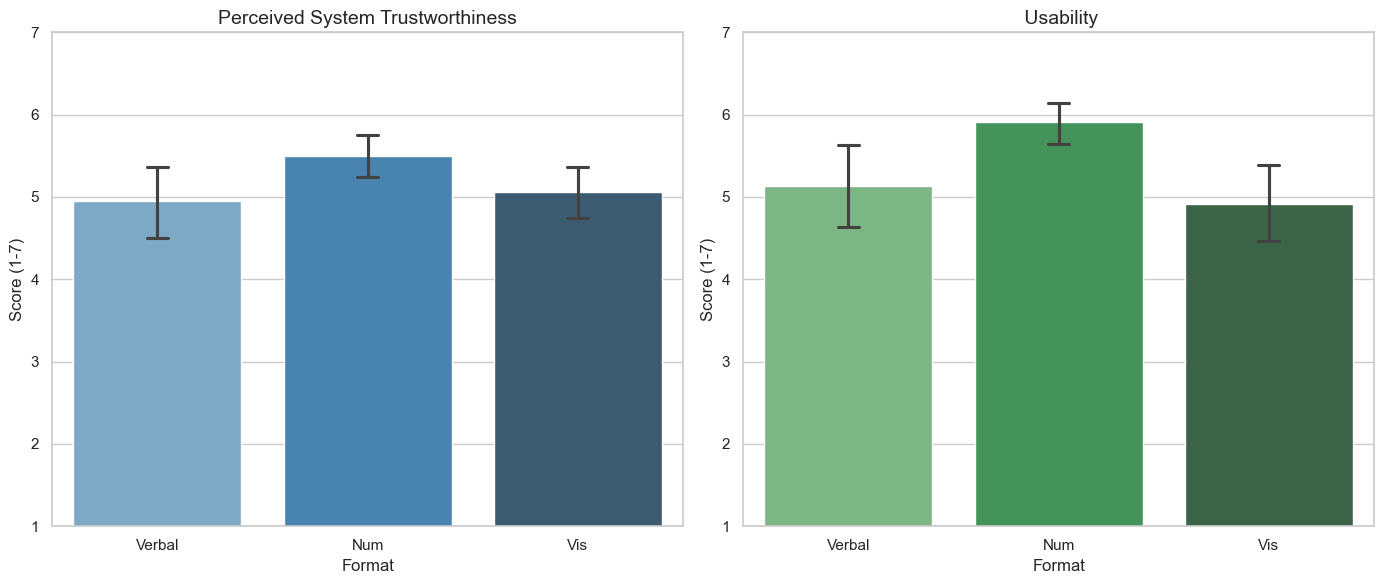

Chart has been saved as 'results.png'.


In [11]:
# Create plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Trustworthiness Plot
sns.barplot(x='Condition', y='Score', data=df_long_trust, ax=axes[0], 
            palette="Blues_d", capsize=.1, errorbar='ci')
axes[0].set_title('Perceived System Trustworthiness', fontsize=14)
axes[0].set_ylim(1, 7)
axes[0].set_ylabel('Score (1-7)')
axes[0].set_xlabel('Format')

# Usability Plot
sns.barplot(x='Condition', y='Score', data=df_long_use, ax=axes[1], 
            palette="Greens_d", capsize=.1, errorbar='ci')
axes[1].set_title(' Usability', fontsize=14)
axes[1].set_ylim(1, 7)
axes[1].set_ylabel('Score (1-7)')
axes[1].set_xlabel('Format')

plt.tight_layout()
plt.show()

# Save
fig.savefig("results_diagram.png", dpi=300)
print("Chart has been saved as 'results.png'.")